In [10]:
:e ImportQualifiedPost
:e FlexibleContexts
:e BlockArguments
:e TupleSections
:e FlexibleContexts
:e OverloadedStrings
:e LambdaCase

import qualified Data.Text as T
import Control.Arrow (first,second)
import Control.Monad
import Graphics.Vega.VegaLite hiding (density)
import qualified Graphics.Vega.VegaLite as VL
import IHaskell.Display.Hvega (vlShow)

import Control.Monad.Bayes.Class
import Control.Monad.Bayes.Enumerator

import Control.Monad.Bayes.Weighted
import Control.Monad.Bayes.Sampler.Strict
import Control.Monad.Bayes.Traced.Static
import Control.Monad.Bayes.Inference.MCMC

:l ../plotting.hs

Failed to load module Plotting
• Couldn't match type ‘aeson-2.0.3.0:Data.Aeson.Types.Internal.Value’ with ‘(VLProperty, VLSpec)’
  Expected: PropertySpec
    Actual: aeson-2.0.3.0:Data.Aeson.Types.Internal.Value
• In the expression: linePlotSpec
  In the first argument of ‘toVegaLite’, namely ‘[linePlotSpec, scatterplotSpec]’
  In the second argument of ‘($)’, namely ‘toVegaLite [linePlotSpec, scatterplotSpec]’
• Couldn't match type ‘aeson-2.0.3.0:Data.Aeson.Types.Internal.Value’ with ‘(VLProperty, VLSpec)’
  Expected: PropertySpec
    Actual: aeson-2.0.3.0:Data.Aeson.Types.Internal.Value
• In the expression: scatterplotSpec
  In the first argument of ‘toVegaLite’, namely ‘[linePlotSpec, scatterplotSpec]’
  In the second argument of ‘($)’, namely ‘toVegaLite [linePlotSpec, scatterplotSpec]’

# MCMC

Following [wikipedia](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo):

> Markov chain Monte Carlo (MCMC) is a powerful class of methods to sample from probability distributions known only up to an (unknown) normalization constant.

Markov Chain is a stochastic process where new state depends only on the previous state (Markov property for discrete-time process). Transition between states is governed by transition kernell $T$. In the limit of long simulation, probability distribution of steps of the Markov process converges to the stationary distribution $\pi_{\star}$ under assumptions of existence of the stationary distribution, non-periodicy of MC and availibility of all states.

If we want to **sample** from a complicated distribution $\pi$, we can construct a Markov process which stationary distribution $\pi_{\star} = \pi$. The question is how to construct transition kernell to achieve $\pi$ as a stationary distribution.

## Metropolis-Hastings
MH is a classical and most widely use algorithm with many flavours. Here we present the general outline.

The algoritm is used to generate next point of the Markov Chain ($x_{i+1}$) in the space state.
MH algorithms consist of proposal and acceptance/rejection steps:
1. **Proposal**: draw next candidate\
    We construct transition kernel:

    $$ 
    T(x_{i+1}|x_{i}) = q(x_{i+1}|x_{i})\times p_{acc}(x_{i+1}|x_{i})
    $$
    where $q$ is proposal distribution for the next state of the chain and $p_{acc}$ is probability of sample being accepted.

    Proposal distribution $q$ should be simple to draw from, for example uniform distribution around current point $\mathcal{U}(x_i - \delta, x_{i}+\delta)$, where $\delta$ is a small positive number. 
    At first step of 
2. **Acceptance/rejection** assess if the candidate might have been drawn from sampled distribution $\pi$\
    Having symmetric proposal distribution and adding constraint of microscopic reversibility on the transition kernell:

    $$ 
    \pi(x_{i})T(x_{i+1}|x_{i}) = \pi(x_{i+1})T(x_{i}|x_{i+1})
    $$

    we have acceptance probability:
    $$
    p_{acc}(x_{i+1}|x_{i}) = min\left\{1, \frac{\pi_{x+1}}{\pi_{x}}\right\}
    $$

For details on MCMC see the series of blog posts starting with https://www.tweag.io/blog/2019-10-25-mcmc-intro1/ or an online book https://bookdown.org/rdpeng/advstatcomp/markov-chain-monte-carlo.html.



## `monad-bayes` implementation
There are several versions of Metropolis-Hastings algorith for MCMC defined in monad-bayes. The standard version is found in `Control.Monad.Bayes.Inference.MCMC` - Traced MH.
Implementatio of a single step of of MH algorithm is `mhTransWithBool`.



# Linear regression

We'll start with the example of a simple regression. Function `regressionData` defines a distribution of a linear regression values given a list of arguments.

In [23]:
paramPriorRegression = do
    slope <- normal 0 2
    intercept <- normal 0 2
    noise <- gamma 4 4
    return (slope, intercept, noise)


regressionData :: (MonadDistribution m, Traversable t) => t Double -> m (t (Double, Double))
regressionData xs = do
    (slope, intercept, noise) <- paramPriorRegression
    forM xs \x -> do
        y <- normal (x*slope + intercept) (sqrt noise)
        return (x, y)

In [24]:
range = [-10,-9.9..10] :: [Double]
regressionSamples <- sampleIOfixed $ regressionData range

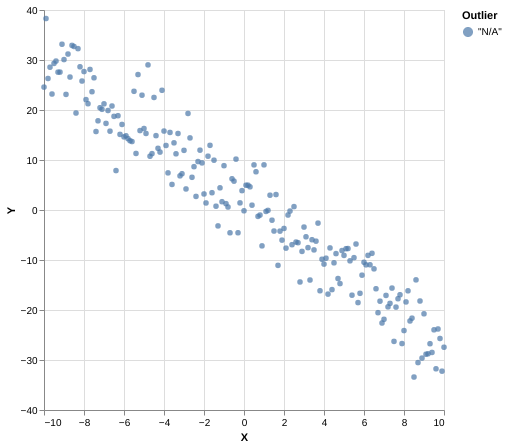

In [89]:
plot (zip regressionSamples (Prelude.repeat $ T.pack "N/A"))

Function`regression` computes paramteres of the model, namely `(slope, intercept, noise)` and their score.

In [74]:
regression :: (MonadMeasure m) => [Double] -> [Double] -> m (Double, Double, Double)
regression xs ys = do
    params@(slope, intercept, noise) <- paramPriorRegression
    forM_ (zip xs ys) \(x, y) -> factor $ normalPdf (slope * x + intercept) (sqrt noise) y
    return (slope, intercept, noise)

In [75]:
mcmcConfig = MCMCConfig {numMCMCSteps = 1000, numBurnIn = 500, proposal = SingleSiteMH}
mhRunsRegression <- sampleIOfixed . unweighted . mcmc mcmcConfig $ uncurry regression (unzip regressionSamples)

A linear model 

In [79]:
:i vlShow

vlShow :: VegaLite -> VegaLiteLab 	-- Defined in ‘IHaskell.Display.Hvega’

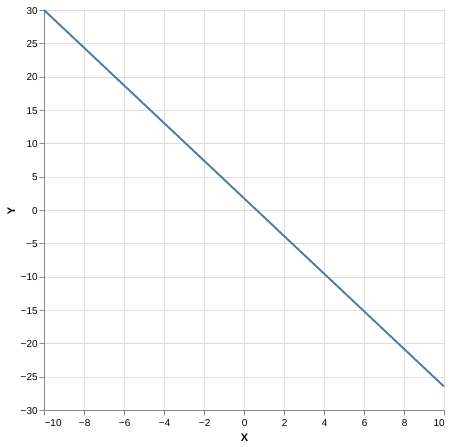

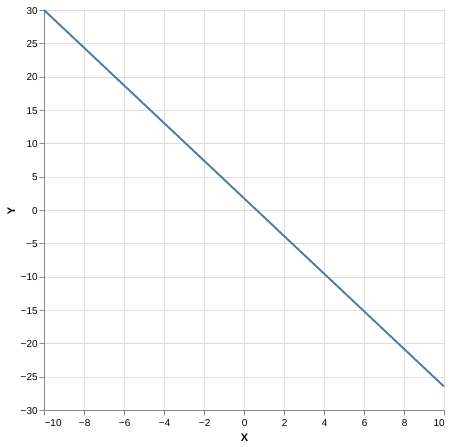

In [77]:
plot (range, (\(s,i,_) -> (s,i)) $ head mhRunsRegression) 
plot (range, (\(s,i,_) -> (s,i)) $ head mhRunsRegression) 


This is a sample from the MCMC walk. Since this is an easy inference problem, it wasn't hard to generate good samples.

We can also view the posterior predictive, as follows:

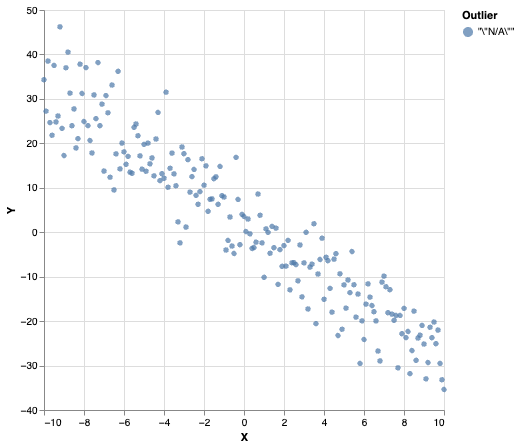

In [7]:
posteriorPredictive :: MonadMeasure m => [Double] -> [Double] -> m [Double]
posteriorPredictive xs ys = do
    (slope, intercept, noise) <- regression xs ys
    forM xs \x -> do
            let y' = x * slope + intercept
            normal y' (sqrt noise)


predictive <- head <$> (sampleIOfixed $ unweighted $ mcmc mcmcConfig $ posteriorPredictive range (snd <$> regressionSamples))
plot (fmap (second (T.pack . show)) (zip (zip range predictive) (Prelude.repeat "N/A")))


# Linear regression with outliers

Inspired by the tutorials on probabilistic programming language Gen (https://www.gen.dev/tutorials/iterative-inference/tutorial), we'll make the inference problem harder by using the example of a regression with outliers. The idea is that each datapoint $(x,y)$ has $y$ either linearly dependent on $x$, or randomly sampler (an outlier). So the goal of inference is to *jointly* work out what the linear relationship is and which points flout it.

In [8]:
paramPrior = do
    slope <- normal 0 2
    intercept <- normal 0 2
    noise <- gamma 4 4
    prob_outlier <- uniform 0 0.5 
    return (slope, intercept, noise, prob_outlier)

forward (slope, intercept, noise, probOutlier) x = do
    isOutlier <- bernoulli probOutlier
    let meanParams = if isOutlier
                    then (0, 20)
                    else (x*slope + intercept, sqrt noise)
    return (meanParams, isOutlier)

regressionWithOutliersData :: (MonadDistribution m, Traversable t) => t Double -> m (t ((Double, Double), Bool))
regressionWithOutliersData xs = do
    params <- paramPrior

    forM xs \x -> do
        ((mu, std), isOutlier) <- forward params x
        y <- normal mu std
        return ((x, y), isOutlier)

This is our model. It describes a process for getting $y$ from $x$. Specifically, you start by drawing values for the slope $s$, bias $b$ and noise $n$. Then for each input $x$, you flip a coin. If it lands one way, you draw a $y$ value from a normal with mean $x*slope + bias$ and std $n$, and otherwise you draw from a centered normal with large variance.

Given a list of $x$ values, this gives a distribution over lists of $y$ values, from which we can sample:




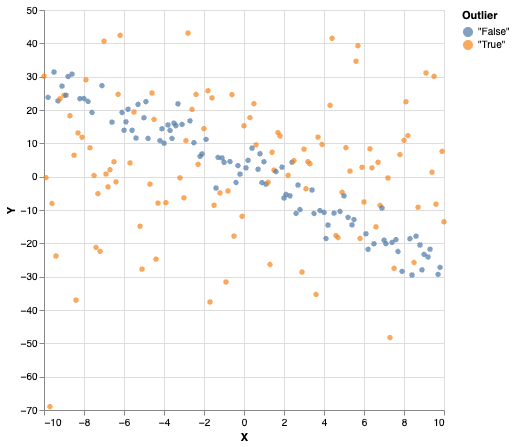

In [9]:
range = [-10,-9.9..10] :: [Double]
samples <- sampleIOfixed $ regressionWithOutliersData range
plot (fmap (second (T.pack . show)) samples)


<!-- This is our dataset, with outliers shown in orange.

Given this dataset of $(x,y)$ pairs, we now consider the problem of inference. That is, we want to infer the slope, bias, noise and *for each datapoint*, whether it's an outlier.

Our first attempt will be to average a large number of samples, weighted by how likely they are. TODO: add the conditioning
 -->

<!-- Why did this result in a bad guess? Simply because there are so many more bad guesses than good ones, so that even if you weight the good guesses higher, if you have almost none, then it doesn't matter.

The classic solution to this problem (the solution space is too large for independent sampling) is to use a Markov Chain method, where each sample depends on the last. You can do so in a clever way, to obtain unbiased samples from the true posterior distribution in the limit of a sufficiently long chain. Monad-bayes implements the standard Markov Chain Monte Carlo approach with Metropolis Hastings transitions.

Here's how it goes: -->

In [10]:
regressionWithOutliers :: (MonadMeasure m) =>
    [Double] -> [Double] -> m ((Double, Double, Double, Double), [Bool])
regressionWithOutliers xs ys = do
    params <- paramPrior
    
    outliers <- forM (zip xs ys) \(x, y) -> do
        ((mu, std), isOutlier) <- forward params x
        factor $ normalPdf mu std y
        return isOutlier
    return (params, outliers)

In [11]:

mhRuns <- sampleIOfixed $ unweighted $ mcmc mcmcConfig $ regressionWithOutliers range (snd . fst <$> samples)


In [12]:


outlierProb s = (\(x, y) ->  x / (x+y) )
        <$> (foldr
    \(_,lb) li -> 
        [ if b then (num1+1, num2) else (num1,num2+1) | (b,(num1, num2)) <- zip lb li])
    (Prelude.repeat (0,0)) s


Line 4: Redundant bracket
Found:
(foldr
   \ (_, lb) li
     -> [if b then (num1 + 1, num2) else (num1, num2 + 1) |
           (b, (num1, num2)) <- zip lb li])
  (Prelude.repeat (0, 0))
Why not:
foldr
  \ (_, lb) li
    -> [if b then (num1 + 1, num2) else (num1, num2 + 1) |
          (b, (num1, num2)) <- zip lb li]
  (Prelude.repeat (0, 0))

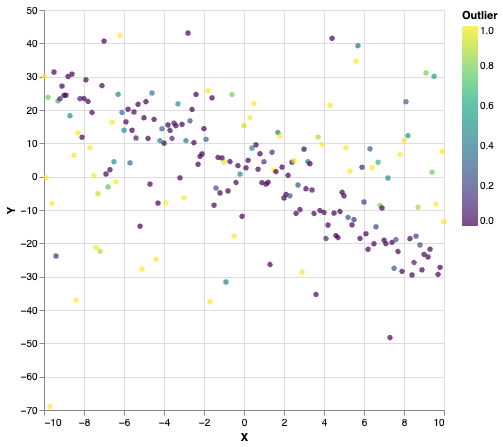

In [13]:
plot  $ take 5000 (zip (fst <$> samples) (outlierProb mhRuns))

Running MCMC gives us a list of samples. The results make sense: points that are very near the line are probably not outliers and ones very far are. 

It would be nice to make our approach more sample efficient though. The `SingleSiteMH` proposal is very naive. Two ways to improve on this would be to use customizable proposals, as in `Gen`, or to use Hamiltonian Monte Carlo as in `Stan`.